General workflow:
------
* 1. convert PDF to gray scale images
    *  [x] 1.1 for local version just make sure the pdf is in an empty folder
    *  [ ] 1.2 needs some design for online service version; 
        * 1.2.1 make sure that only one user at a time by throw back 'server in use' (can check on multiuser app later)
        * 1.2.2 save the user-uploaded pdf; convert and save images to a destinated folder; clear folder after task
        * 1.2.3 need a timer to monitor and shut down inactive user; clear folder if confirmed inactive 
* 2. establish template, 4 corner anchors are manually input for now
    *  [x] 2.1 for online version, with preprint form,  the TLBR points for each roi can be calculated (ID is fixed, ANS can be determined by Q length)
    *  [x] 2.2 for local version that handle customized forms, roi TLBR are visulized and manually input for now
* 3. process images and combine results
    * clear output folder
    * for each image:
    *  [x] 3.1 read image, resize if nececcary; rotate image if id box is not found in the top-right region; align image;
        * [x] i. if fail, image with last attempt saved as 'e<filename>'; move on to next image; assert when more than 5 alignment failure occur
        * [x] ii. if good, 'alignment succeeded'
    *  [x] 3.2 extract responses; check ROIs (ans and ids combined) for filled answers; 
        * [x] i. if non-fill or multi-fill in any entry, entry with quetionalbe answers are highlighted, image labeled and save as 'b<filename>'; move on to next image
        * [x] ii. if good, extracted answers highlighted, image save as 'a<filename>'
* 4. generate output files
    * [x] 3.1 group output images by outcome type (e for alignment error, b for questionalbe, a for normal), sort each group in student id order, combine them into one pdf file for review. 
    * [x] 3.2 save output as a .csv file for BubbleProcess


### some thoughts for future improvement:
* . directory check and reuse
* . autoadjust region of interest(ROI)
* . exam analysis

In [1]:
# Standard imports
import tempfile
import os
import time
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from fpdf import FPDF
%matplotlib inline
from scipy.signal import convolve2d
import argparse
import cv2
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np;

In [2]:
# parameters
PDFINPUT = 'test0089.pdf'

PATH = os.path.dirname(os.path.realpath('__file__'))
SRC_IMG = 'srcimg'
OUT_IMG = 'outimg'
CORNERS = np.array([[ 222.,   124. ], [ 222.,  2023], [1521,  124. ], [1521, 2023]])
CORNER_RATIO = (('r', 2200, 250, 1830), ('c', 1700, 350,1350))

IDS = [[3,'0123456789',1]]        
ANSWERS = [[35,'ABCDE',0]]    

In [3]:
def process_ans(a):
    if a[0][0] <= 50:
        return a
    elif a[0][0] <= 100:
        return [[50,'ABCDE',0],[a[0][0]-50,'ABCDE',0]]
    else:
        assert(False), "this scantron can not handle more than 100 questions"
ANSWERS = process_ans(ANSWERS)

def find_TLBR(a):
    tlbr = [[(363,202),(523,1772)],[(615,202),(818,1772)],[(985,425),(1065,714)]]
    h = (1772-202)/49
    b = []
    for i, ans in enumerate(a):
        b.append([tlbr[i][0],(tlbr[i][1][0], tlbr[i][0][1]+int(h*(ans[0]-1)))])
    b.append(tlbr[2])
    return b
TLBR = find_TLBR(ANSWERS)
print(TLBR)

[[(363, 202), (523, 1291)], [(985, 425), (1065, 714)]]


In [4]:
def clear_dir(path):
    os.makedirs(path, exist_ok=True)
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))

def convert_pdf(PDFINPUT, srcimg):
    clear_dir(srcimg)
    with tempfile.TemporaryDirectory() as path:
        images_from_path = convert_from_path(PDFINPUT, output_folder=path) #, grayscale=True # cause weird racing problem
        cnt = 0
        for image in images_from_path:
            cnt += 1
            image.save("{}\Image{:03d}.jpg".format(srcimg, cnt), "JPEG")
    return cnt

In [5]:
def build_roi(item, tlbr):
    radius = 15
    top_left, bottom_right = tlbr[0], tlbr[1]
    entries, options, orientation = item
    if (orientation == 0):
        xs = np.linspace(top_left[0],bottom_right[0],len(options)).astype(int)
        ys = np.linspace(top_left[1],bottom_right[1],entries).astype(int)
        circles = np.array([[x,y,radius] for y in ys for x in xs])
    else:
        xs = np.linspace(top_left[0],bottom_right[0],entries).astype(int)
        ys = np.linspace(top_left[1],bottom_right[1],len(options)).astype(int)
        circles = np.array([[x,y,radius] for x in xs for y in ys])
    print('building roi',circles.shape,circles[0],circles[-1])
    
    return circles

In [6]:
# align image
def get_corners(im):
    print('get corners')
    gc = im.copy()
    _r1, _r2 = int(CORNER_RATIO[0][2]/CORNER_RATIO[0][1]*im.shape[0]), int(CORNER_RATIO[0][3]/CORNER_RATIO[0][1]*im.shape[0])
    _c1, _c2 = int(CORNER_RATIO[1][2]/CORNER_RATIO[1][1]*im.shape[1]), int(CORNER_RATIO[1][3]/CORNER_RATIO[1][1]*im.shape[1])
    gc[_r1:_r2] = 255
    gc[:,_c1:_c2] = 255
    
    _, gc = cv2.threshold(gc, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5,5),np.uint8)
    gc = cv2.morphologyEx(gc,cv2.MORPH_CLOSE,kernel)
    gc = cv2.morphologyEx(gc,cv2.MORPH_OPEN,kernel)
    gc = cv2.erode(gc,kernel,iterations = 3)
    gc = cv2.GaussianBlur(gc, (7, 7), 0)
    
#     img_contoured = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2BGR)
    _, contours,hierarchy = cv2.findContours(gc.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     print(len(contours))
    if len(contours) > 4: contours = sorted(contours, key=lambda x: cv2.arcLength(x, False)/cv2.contourArea(x))[:4]

#     cv2.drawContours(img_contoured, contours, -1, (255,0,0), 2) 
    
#     img_fitted = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2BGR)
#     cv2.drawContours(img_fitted, contours, -1, (255,0,0), -1)
    circles = []
    for c in contours:
        (x,y), r = cv2.minEnclosingCircle(c)
        x,y,r = int(x), int(y), int(r)
#         cv2.circle(img_fitted, (x,y),r,(0,255,0),2)
        circles.append([x,y,r])
    
#     print(circles)
    
#     fig = plt.figure(figsize = (18,15))
    
#     fig.add_subplot(121)
#     plt.imshow(img_contoured, cmap = 'gray')
#     fig.add_subplot(122)
#     plt.imshow(img_fitted, cmap='gray')
    
    circles = np.array(circles)
    if len(circles) != 4: return circles
    df = circles[:,:2]
    df = df[df[:,0].argsort()]
#     print(df)
    a, b = df[:2], df[2:]
    a = a[a[:,1].argsort()]
    b = b[b[:,1].argsort()]
    df = np.vstack([a,b])
    return df

def align_img(img, alignment):
    print('align_img')
    points1 = get_corners(img)
    points2 = alignment
    
    if (points1 is None or len(points1) != 4):
        img_circled = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if points1 is not None:
            cv2.putText(img_circled, "Cannot find 4 corners!!!",
                       (200,200), cv2.FONT_HERSHEY_SIMPLEX, 5, (0,0,255),
                       10, cv2.LINE_AA)
            for i in range(len(points1)):
                c = points1[i]
                cv2.circle(img_circled, (c[0], c[1]), 60, (0, 255, 0), 4)
        else:
            cv2.putText(img_circled, "Cannot find any corner!!!",
                       (200,200), cv2.FONT_HERSHEY_SIMPLEX, 5, (0,0,255),
                       10, cv2.LINE_AA)
        return img_circled, []
    
    print(points1-points2)
        
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    if len(img.shape) == 3:
        height, width, _ = img.shape
    else:
        height, width = img.shape
    im1Reg = cv2.warpPerspective(img, h, (width, height))

    return im1Reg, h

In [7]:
def rotate_img(img):
    tl, rb = TLBR[-1][0], TLBR[-1][1]
    im = img[(tl[1]-125):(tl[0]-185),(rb[1]+185):(rb[0]+135)]
    _, gc = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY_INV)
    gc = cv2.GaussianBlur(gc, (5, 5), 0)
    _, contours,hierarchy = cv2.findContours(gc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)[:3]
#     cimg = cv2.cvtColor(gc, cv2.COLOR_GRAY2BGR)
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
#         print(x,y,w,h)
#         cv2.rectangle(cimg, (x,y),(x+w,y+h),(0,255,0),2)
        if (x-67)*(x-67)+(y-80)*(y-80) < 1500 and w*h > 130*350 and w*h < 140*370:
#             plt.imshow(cimg, cmap='gray')
            return img
#     plt.imshow(cimg, cmap='gray')
    return cv2.rotate(img, cv2.ROTATE_180)

In [8]:
# process img
def process_img(img, rois, items, outimg):
    print('processing image...')
    res = []
    t = 'a'
    circled_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    for roi, item in zip(rois, items):        
        circles_sorted = roi # circles_rounded[circles_rounded[:,1].argsort()]

        circle_radius = 7
        kernel = np.ones((2*circle_radius,2*circle_radius),dtype=int)
        out0 = convolve2d(255-img, kernel,'same')
        detected_vals = out0[circles_sorted[...,1], circles_sorted[...,0]]
#         detected_vals -= detected_vals.min()

        mask = detected_vals>20000 # detected_vals.max()/2

        ans = []
        choices = item[1]

        for i in range(0, len(circles_sorted), len(choices)):
            a, v = '', 0
            cnt = mask[i:i+len(choices)].sum()
#             print(int(i/len(choices)), cnt)
            if cnt != 1:
                t = 'b'
                c1, c2 = circles_sorted[i], circles_sorted[i+len(choices)-1] 
                if c1[0] == c2[0]: # vertical
                    p1, p2 = (c1[0]+c1[2]+3, c1[1]-c1[2]), (c2[0]+c2[2]+3, c2[1]+c2[2]*3)
                else: # horizontal
                    p1, p2 = (c1[0]-c1[2], c1[1]+c1[2]+3), (c2[0]+c2[2]*3, c2[1]+c2[2]+3)
                cv2.line(circled_img,p1,p2,(255,0,0),1)
                cv2.putText(circled_img, '*', p2, cv2.FONT_HERSHEY_SIMPLEX,
                            1, (255,0,0), 3, cv2.LINE_AA)
            if cnt == 0:
                for j in range(len(choices)):
                    c = circles_sorted[i+j]
                    cv2.circle(circled_img, (c[0],c[1]), c[2], (0,205,0), 1)
                
            elif cnt > 1:
                for j in range(len(choices)):
                    if mask[i+j]==1:
                        c = circles_sorted[i+j]
                        a = choices[j] if detected_vals[i+j] > v else a
                        v = detected_vals[i+j] if detected_vals[i+j] > v else v
                        cv2.circle(circled_img, (c[0],c[1]), c[2], (0,255,0), 3)
                c = circles_sorted[i+choices.find(a)]
                cv2.putText(circled_img, a, (c[0], c[1]), cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0,0,255), 3, cv2.LINE_AA)
                
            else:
                for j in range(len(choices)):
                    if mask[i+j]==1:
                        c = circles_sorted[i+j]
                        a = choices[j]
                        cv2.circle(circled_img, (c[0],c[1]), c[2], (0,255,0), 3)
                        cv2.putText(circled_img, a, (c[0], c[1]), cv2.FONT_HERSHEY_SIMPLEX,
                                   1, (0,0,255), 3, cv2.LINE_AA)
            
            ans.append(a)        

        res.extend(ans)
    if t == 'b':
        cv2.putText(circled_img, '***', (320,130), cv2.FONT_HERSHEY_SIMPLEX,
                            4, (255,0,0), 8, cv2.LINE_AA)
    return res,t, circled_img

In [9]:
# process imgs
def process_imgs(srcimg, rois, items, outimg, image_scanned):
    clear_dir(outimg)
    res, err = [], []
    start = time.time()
    print('processing images ... ...')
    # fetch each image
    for i, filename in enumerate(os.listdir(srcimg)):
        print(i+1, filename)
#         if i > 0: break
        img = cv2.imread("{}\{}".format(srcimg,filename),0)
        if img.shape != (2200,1700): img = cv2.resize(img, (1700,2200))
        img = rotate_img(img)
        img, _ = align_img(img, CORNERS)
        
        if len(_) == 0:
            err.append(filename)
            assert (len(err) < 5), '\nAlignment on five (5) or more images failed.\
            \nPlease check input file and resubmit.'
            cv2.imwrite("{}\{}{}".format(outimg,'e',filename), img)
            continue
        
        r, t, proc_img = process_img(img, rois, items, outimg)
        entry = [t+filename[:-4]]
        entry.extend(r)
        res.append(";".join(entry))
        cv2.imwrite("{}\{}{}".format(outimg,t,filename), proc_img)
    print('''{} images processed in {:.03f} s ({:.02f} s/image).
    with {} success and {} errors.'''.format(
        len(res) + len(err), (time.time()-start), 
        (time.time()-start)/(len(res) + len(err)),
        len(res), len(err)))
    print(res, err)
    return res, err

In [10]:
# generate report
def generate_report(res, err, outimg):
    a, b = [i for i in res if i[0] == 'a'], [i for i in res if i[0] == 'b']
    a.sort(key = lambda x: ''.join(x[-3:]))
    b.sort(key = lambda x: ''.join(x[-3:]))
    results = err + b + a
    cover = cv2.imread("{}\{}.jpg".format(outimg,results[0][:9]))
    plt.figure(figsize=(8,8))
    plt.imshow(cover)
    print(cover.shape)
    w,h = cover.shape[1],cover.shape[0]
    pdf = FPDF(unit = 'pt', format = [w,h])
    for filename in results:
        pdf.add_page()
        pdf.image("{}\{}.jpg".format(outimg,filename[:9]),0,0,w,h)
    pdf.output("{}\\re.pdf".format(outimg), "F")
    df = pd.DataFrame(results)
    df.to_csv("{}\\re.csv".format(outimg),index = False,header=False)
    pass

In [11]:
def main(PDFINPUT, SRC_IMG, OUT_IMG, IDS, ANSWERS):
    PATH = os.path.dirname(os.path.realpath('__file__'))
    srcimg = os.path.join(PATH, SRC_IMG)
    outimg = os.path.join(PATH, OUT_IMG)
    print("source images @ {}".format(srcimg))
    print("Output images @ {}".format(srcimg))
    t1 = time.time()
    image_scanned = convert_pdf(PDFINPUT, srcimg)
    t2 = time.time()
    print('{} pages converted into JPEG. {:.02f} s used. {:.02f} s/page'.format(
        image_scanned, t2-t1, (t2-t1)/image_scanned))
    firstImg = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)

    items = ANSWERS+IDS
    rois = [build_roi(item, tlbr) for item,tlbr in zip(items, TLBR)]
#     print(*rois, sep='\n')

    res, err = process_imgs(srcimg, rois, items, outimg, image_scanned)
    t3 = time.time()
    print('Image processing complete. {:.02f} s total. {:.02f} s/image'.format(
        t3-t2, (t3-t2)/image_scanned))

    generate_report(res, err, outimg)
    t4 = time.time()
    print('Report generated. {:.02f} s total. {:.02f} s/page'.format(
        t4-t3, (t4-t3)/image_scanned))
    print('Grading complete. {:.02f} s total. {:.02f} s/page'.format(
        t4-t1, (t4-t1)/image_scanned))

source images @ C:\Users\xzhang\Documents\Jupyter\tests\srcimg
Output images @ C:\Users\xzhang\Documents\Jupyter\tests\srcimg
89 pages converted into JPEG. 41.88 s used. 0.47 s/page
building roi (175, 3) [363 202  15] [ 523 1291   15]
building roi (30, 3) [985 425  15] [1065  714   15]
processing images ... ...
1 Image001.jpg
align_img
get corners
[[ -7.  -6.]
 [ -1.  -7.]
 [-11.  -9.]
 [ -3. -10.]]
processing image...
2 Image002.jpg
align_img
get corners
[[ -6.  -5.]
 [  0.  -5.]
 [-11.  -5.]
 [ -6.  -6.]]
processing image...
3 Image003.jpg
align_img
get corners
[[ -5.  -2.]
 [  0.  -3.]
 [-12.  -5.]
 [ -6.  -6.]]
processing image...
4 Image004.jpg
align_img
get corners
[[-15. -17.]
 [-13. -18.]
 [-21. -21.]
 [-16. -21.]]
processing image...
5 Image005.jpg
align_img
get corners
[[-5. -7.]
 [-1. -7.]
 [-7. -8.]
 [-4. -7.]]
processing image...
6 Image006.jpg
align_img
get corners
[[ -6.  -4.]
 [  0.  -4.]
 [-10.  -6.]
 [ -5.  -7.]]
processing image...
7 Image007.jpg
align_img
get corner

74 Image074.jpg
align_img
get corners
[[-16. -12.]
 [-11. -13.]
 [-22. -17.]
 [-15. -16.]]
processing image...
75 Image075.jpg
align_img
get corners
[[-14.  -9.]
 [-13. -10.]
 [-19. -12.]
 [-13. -13.]]
processing image...
76 Image076.jpg
align_img
get corners
[[-14.  -9.]
 [-11. -11.]
 [-17. -12.]
 [-11. -13.]]
processing image...
77 Image077.jpg
align_img
get corners
[[ -6.   1.]
 [  1.   1.]
 [-11.   0.]
 [ -5.   0.]]
processing image...
78 Image078.jpg
align_img
get corners
[[-14. -16.]
 [-12. -18.]
 [-22. -20.]
 [-16. -20.]]
processing image...
79 Image079.jpg
align_img
get corners
[[-4.  1.]
 [ 2.  1.]
 [-8.  0.]
 [-1. -2.]]
processing image...
80 Image080.jpg
align_img
get corners
[[-13. -10.]
 [-11. -11.]
 [-15. -13.]
 [-10. -13.]]
processing image...
81 Image081.jpg
align_img
get corners
[[-5.  4.]
 [ 1.  3.]
 [-9.  3.]
 [-3.  2.]]
processing image...
82 Image082.jpg
align_img
get corners
[[ -7.  -1.]
 [  1.   0.]
 [-12.  -2.]
 [ -4.  -3.]]
processing image...
83 Image083.jpg
a

Report generated. 31.69 s total. 0.36 s/page
Grading complete. 351.72 s total. 3.95 s/page


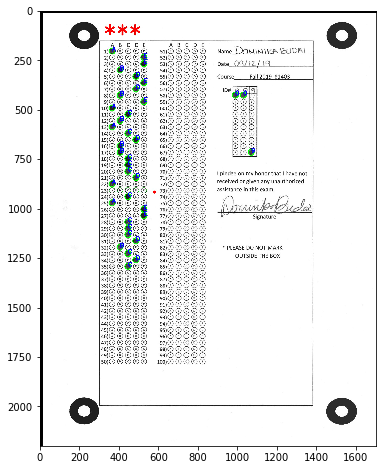

In [12]:
main(PDFINPUT, SRC_IMG,OUT_IMG, IDS, ANSWERS)

In [ ]:
# test
def checkfilled(img, rois, items):
    '''
    check OMR threshhold
    '''
    circled_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    for roi, item in zip(rois, items):        
        circles_sorted = roi # circles_rounded[circles_rounded[:,1].argsort()]

        circle_radius = 7
        kernel = np.ones((2*circle_radius,2*circle_radius),dtype=int)
        out0 = convolve2d(255-img, kernel,'same')
        detected_vals = out0[circles_sorted[...,1], circles_sorted[...,0]]
#         detected_vals -= detected_vals.min()

        mask = detected_vals>20000
        for i in range(0,len(mask),10):
            print(int(i/10+1), sorted(detected_vals[i:i+10]))
            print(mask[i:i+10])
    
def debug_checkfilled():
    PATH = os.path.dirname(os.path.realpath('__file__'))
    srcimg = os.path.join(PATH, SRC_IMG)
    firstImg = cv2.imread('{}\Image011.jpg'.format(srcimg), 0)
    items = ANSWERS+IDS
    rois = [build_roi(item, tlbr) for item,tlbr in zip(items, TLBR)]
    checkfilled(firstImg, rois, items)
# debug_checkfilled()

In [ ]:
# building template by label all roi boundaries
def label_img(img):
    img, _ = align_img(img, CORNERS)
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=0.9, minDist=22, 
                               param1 = 30, param2 = 20, minRadius = 12, maxRadius = 18)
#     print(circles)
    df = np.array(circles[0]).astype(int)
    dfa = df[df[:,0]<900]
    dfb = df[df[:,0]>900]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    def find_groups(df):
        x = []
        s, f, c = 0, 0, 0
        while f < len(df):
            if df[f] < df[s] + 10:
                c += df[f]
                f += 1
            else: 
#                 x.append(df[s:f])
                x.append(int(c/(f-s)))
                c = 0
                s = f
        x.append(int(c/(f-s)))
        return x
    def label_area(dfa):
        df1 = dfa[dfa[:,0].argsort()] #sorted(df, key=lambda x: x[0])
        df2 = dfa[dfa[:,1].argsort()]
        df1 = df1[:,0]
        df2 = df2[:,1]
    
        x = find_groups(df1)
        print(x)
        y = find_groups(df2)
        print(y)
    
        for i, xi in enumerate(x):
            cv2.putText(img, str(xi), (xi,y[0]-30-(i%4)*25), cv2.FONT_HERSHEY_SIMPLEX,
                                1, (0,255,0), 3, cv2.LINE_AA)
        for i in y:
            cv2.putText(img, str(i), (x[0]-130,i), cv2.FONT_HERSHEY_SIMPLEX,
                                1, (0,255,0), 3, cv2.LINE_AA)
    label_area(dfa)
    label_area(dfb)
    for i in circles[0]:
        cv2.circle(img, (i[0], i[1]), i[2], (0,0,255), 3)
    plt.figure(figsize=(18,18))
    plt.imshow(img, cmap='gray')

def debug_build_template():
    PATH = os.path.dirname(os.path.realpath('__file__'))
    srcimg = os.path.join(PATH, SRC_IMG)
    firstImg = cv2.imread('{}\Image001.jpg'.format(srcimg), 0)
    label_img(firstImg)
# debug_build_template()

### developer journal
* __2019.10.04__ in this week, simplified the logic, modified the frame, optimized algorithm, implemented auto-rotation, roi visulization.
    * instead of putting heavy load on alignment where cross reference functions in processing, prebuild the anchors; for each image, resize if necessary (have not found any case yet, maybe the convert to image package took care of it), search for the id box in top-right region, if not found, rotate 180. then align image for processing
    * processing time is now **'Grading complete. 438.97 s total. 4.93 s/page'**
    * label_img use hough_circle to label the roi boundries.


* __2019.9.23__ almost done with process_imgs. make find_corners harsher to force misalignment and errors. the catcher seems working. the Hough circle method is not very robust, probably need countours + area filter -> weight centroid instead.
     * new find_corners implemented. alignment looks neat and sharp now.

13 images processed in 160.509 s (12.35 s/image).
    with 13 success and 0 errors.
    
 * output as pdf and csv. 2019.9.24 test with 89 pages.
 
     - 89 pages converted into JPEG. 41.35 s used. 0.46 s/page
     - 89 images processed in 1124.142 s (12.63 s/image). with 89 success and 0 errors.
     - Grading complete. 1198.04 s total. 13.46 s/page
     
* __2019.9.22__  adjust processing logic. add read ids. now 3 misses in 13 * (35 + 3) readings. saving outputs along the way is not slowing the program down.
    * before adjusting threshhold to fix the misses. implement catcher for exams that have either 0 or more than 1 answers for any question. if 0 answer, circle all options the program checked; if more than 1, circle all answers
    
13 images processed in 159644.334 ms.
    with 13 success and 0 errors.
 ['Image001;B;E;C;A;D;D;D;D;E;C;C;B;C;C;D;C;D;C;E;B;A;B;C;C;D;B;A;D;A;C;D;A;C;B;A;0;1;5', 'Image002;B;E;E;D;D;E;D;E;E;B;C;B;A;C;D;A;E;D;C;C;B;B;A;C;A;B;;B;C;;;B;;;;0;8;1', 'Image003;D;E;E;A;D;D;C;D;E;B;C;B;B;C;D;B;E;A;B;B;D;A;B;C;D;A;A;C;A;A;D;B;A;D;D;0;3;4', ...
 
 catcher implemented: 
 13 images processed in 161.699 s (12.44 s/image).
    with 13 success and 0 errors.
 
* __2019.9.21__  framework established. quite a few misses and false results. need to save result image along the way.

3 images processed in 37066.910 ms.
    with 3 success and 0 errors.
['Image001;B;E;C;A;D;D;D;D;E;C;C;B;C;C;D;C;D;C;E;B;A;B;C;C;D;B;A;D;A;C;D;A;C;B;A;A;;B;;;A', 'Image002;B;E;E;D;D;E;D;E;E;B;C;B;A;C;D;A;E;D;C;C;B;B;A;C;A;B;;B;C;;;B;;;;A;;;D;B;', 'Image003;D;E;E;A;D;D;C;D;E;B;C;B;B;C;D;B;E;A;B;B;D;A;B;C;D;A;A;C;A;A;D;B;A;D;D;A;;D;;E;'] []